https://github.com/mmp-practicum-team/mmp_practicum_fall_2019/blob/master/Tasks/Task3/task3.pdf

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import minimize_scalar


class RandomForestMSE:
    def __init__(self, n_estimators, max_depth=None, feature_subsample_size=None,
                 **trees_parameters):
        """
        n_estimators : int
            The number of trees in the forest.
        
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        
        feature_subsample_size : float
            The size of feature set for each tree. If None then use recommendations.
        """
        self.n = n_estimators
        self.depth = max_depth
        self.subsample_size = feature_subsample_size
        self.tree_params = trees_parameters
        
    def fit(self, X, y):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        y : numpy ndarray
            Array of size n_objects
        """
        if self.subsample_size is None:
            self.subsample_size = 0.33
        self.forest = []
        self.features_subsamples = []
        for i in range(self.n):
            
            train_index = np.random.choice(X.shape[0], X.shape[0], True)
            sub_features = np.random.choice(X.shape[1], int(self.subsample_size * X.shape[1]), replace=False)
            
            regressor = DecisionTreeRegressor(criterion='mse', max_depth=self.depth, **self.tree_params)
            regressor.fit(X[train_index][:, sub_features], y[train_index])
            self.forest.append(regressor)
            self.features_subsamples.append(sub_features)
        
    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        res = np.zeros(X.shape[0])
        for tree, feat in zip(self.forest, self.features_subsamples):
            res += tree.predict(X[:, feat])
        return res / self.n
        
        


class GradientBoostingMSE:
    def __init__(self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
                 **trees_parameters):
        """
        n_estimators : int
            The number of trees in the forest.
        
        learning_rate : float
            Use learning_rate * gamma instead of gamma
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        
        feature_subsample_size : float
            The size of feature set for each tree. If None then use recommendations.
        """
        self.n = n_estimators
        self.lr = learning_rate
        self.depth = max_depth
        self.subsample_size = feature_subsample_size
        self.tree_params = trees_parameters
        
        
    def fit(self, X, y):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        y : numpy ndarray
            Array of size n_objects
        """
            
            
        if self.subsample_size is None:
            self.subsample_size = 0.33
        self.trees = []
        self.coefs = []
        self.features_subsamples = []
        
        acc_res = np.zeros(X.shape[0])
        
        def loss(c):
            res = acc_res + c * regressor.predict(X[:, sub_features])
            return ((res - y)**2).mean()
        
        for i in range(self.n):
            z = 2 * (y - acc_res)
            sub_features = np.random.choice(X.shape[1], int(self.subsample_size * X.shape[1]), replace=False)
            regressor = DecisionTreeRegressor(criterion='mse', max_depth=self.depth, **self.tree_params)
            ind = np.random.choice(X.shape[0], int(0.2 * X.shape[0]), replace=False)
            regressor.fit(X[ind][: , sub_features], z[ind])
            self.coefs.append(minimize_scalar(loss, bounds=(0, 1e+3), method='bounded', \
                                              options={'maxiter':10000})['x'])
            acc_res += self.lr * self.coefs[-1] * regressor.predict(X[:, sub_features])
            self.trees.append(regressor)
            self.features_subsamples.append(sub_features)
            
    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        res = np.zeros(X.shape[0])
        for tree, coef, feat in zip(self.trees, self.coefs, self.features_subsamples):
            res += coef * tree.predict(X[:, feat])
        return self.lr * res

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
from math import floor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

## Тестирование

In [4]:
X, y = make_regression(n_samples=5000, n_features=20, n_informative=15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
rmse_rf = []
mae_rf = []
for n in [10, 50, 100, 250, 500]:
    rf = RandomForestMSE(n_estimators=n, max_depth=None, feature_subsample_size=1)
    rf.fit(X_train, y_train)

    rmse_rf.append(mean_squared_error(rf.predict(X_test), y_test)**0.5)

    mae_rf.append(mean_absolute_error(rf.predict(X_test), y_test))
    
rmse_rf_ = []
mae_rf_ = []    
for n in [10, 50, 100, 250, 500]:
    
    rf_ = RandomForestRegressor(n_estimators=n, criterion='mse', max_depth=None)
    rf_.fit(X_train, y_train)

    rmse_rf_.append(mean_squared_error(rf_.predict(X_test), y_test)**0.5)

    mae_rf_.append(mean_absolute_error(rf_.predict(X_test), y_test))
    

In [6]:
rmse_rf, rmse_rf_, mae_rf, mae_rf_

([108.9149345064878,
  101.75756024803918,
  100.47523980401364,
  100.50661245823039,
  99.83178032902374],
 [109.85707692486336,
  102.61077741269,
  100.59098968058812,
  100.26044779640044,
  100.28147149409597],
 [85.60237430768501,
  79.93626495463815,
  78.50569282484247,
  78.12325780531488,
  77.44680592108331],
 [86.01140055774493,
  79.71133968368977,
  78.33569195642602,
  78.02856685920955,
  77.82359292300792])

In [7]:
rmse_gb = []
mae_gb = []
for n in [100, 200, 500]:
    gb = GradientBoostingMSE(n_estimators=n, learning_rate=0.1, max_depth=3, feature_subsample_size=1)
    gb.fit(X_train, y_train)

    rmse_gb.append(mean_squared_error(gb.predict(X_test), y_test)**0.5)

    mae_gb.append(mean_absolute_error(gb.predict(X_test), y_test))
    
rmse_gb_ = []
mae_gb_ = []    
for n in [100, 200, 500]:
    
    gb_ = GradientBoostingRegressor(n_estimators=n,  criterion='mse', learning_rate=0.1, max_depth=3)
    gb_.fit(X_train, y_train)

    rmse_gb_.append(mean_squared_error(gb_.predict(X_test), y_test)**0.5)

    mae_gb_.append(mean_absolute_error(gb_.predict(X_test), y_test))

In [8]:
rmse_gb, rmse_gb_, mae_gb, mae_gb_

([72.54332599323901, 45.96357043179505, 31.952059126976316],
 [70.96713156948623, 48.23085255102016, 38.42542537264764],
 [56.93357832674925, 35.17186756896574, 24.857848349625797],
 [55.15682115978212, 37.35142722990456, 29.85904300643102])

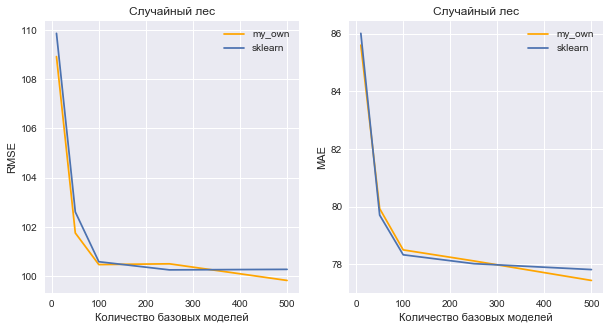

In [9]:
plt.style.use('seaborn')
f = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot([10, 50, 100, 250, 500], rmse_rf, label='my_own', c='orange')
plt.plot([10, 50, 100, 250, 500], rmse_rf_, label='sklearn')
plt.xlabel('Количество базовых моделей')
plt.ylabel('RMSE')
plt.legend()
plt.title('Случайный лес')

plt.subplot(122)
plt.plot([10, 50, 100, 250, 500], mae_rf, label='my_own', c='orange')
plt.plot([10, 50, 100, 250, 500], mae_rf_, label='sklearn')
plt.xlabel('Количество базовых моделей')
plt.ylabel('MAE')
plt.legend()
plt.title('Случайный лес')


f.savefig("correct.pdf")

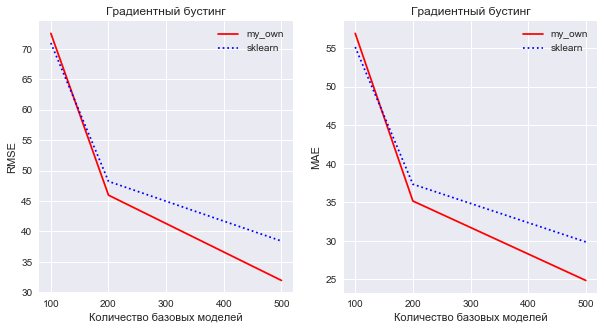

In [10]:
f = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot([100, 200, 500], rmse_gb, label='my_own', c='r')
plt.plot([100, 200, 500], rmse_gb_, label='sklearn', linestyle=':', c='b')
plt.xlabel('Количество базовых моделей')
plt.ylabel('RMSE')
#plt.yscale('log')
plt.legend()
plt.title('Градиентный бустинг')

plt.subplot(122)
plt.plot([100, 200, 500], mae_gb, label='my_own', c='r')
plt.plot([100, 200, 500], mae_gb_, label='sklearn', linestyle=':', c='b')
#plt.yscale('log')
plt.xlabel('Количество базовых моделей')
plt.ylabel('MAE')
plt.legend()
plt.title('Градиентный бустинг')

f.savefig("correct1.pdf")

In [11]:
data = pd.read_csv('train_data.csv')
data = data.drop('index', axis=1)
target = pd.read_csv('train_target.csv')
target = target.drop('index', axis=1)

In [12]:
def str_to_hours(x):
    return datetime.strptime(x, "%Y-%m-%d").timestamp() / 3600
    
data['date'] = data['date'].apply(str_to_hours)
del data['id']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, target.values[:,0], test_size=0.33, random_state=56)

In [14]:
%%time
gb = GradientBoostingMSE(100, max_depth=3, learning_rate=0.1)
gb.fit(X_train.values, y_train)
mean_squared_error(gb.predict(X_test.values), y_test)**0.5

CPU times: user 898 ms, sys: 26.4 ms, total: 924 ms
Wall time: 958 ms


153.76274402029418

In [15]:
rf = RandomForestMSE(100, None, None)
rf.fit(X_train.values, y_train)
mean_squared_error(rf.predict(X_test.values), y_test)**0.5

171.75179113191874

In [16]:
def rf_research(n=100, depth=None, subsample_size=None):
    beg = time.time()
    rf = RandomForestMSE(n_estimators=n, max_depth=depth, feature_subsample_size=subsample_size)
    rf.fit(X_train.values, y_train)
    rmse = mean_squared_error(rf.predict(X_test.values), y_test)**0.5
    end = time.time()
    return rmse, end - beg 

In [17]:
def gb_research(n=100, lr=0.1, depth=3, subsample_size=None):
    beg = time.time()
    gb = GradientBoostingMSE(n_estimators=n, learning_rate=lr, max_depth=depth, feature_subsample_size=subsample_size)
    gb.fit(X_train.values, y_train)
    rmse = mean_squared_error(gb.predict(X_test.values), y_test)**0.5
    end = time.time()
    return rmse, end - beg 

In [18]:
ns = [1] + [i for i in range(10, 210, 10)]
ns_time = []
ns_rmse = []

for i in ns:
    rmse, sec = rf_research(n=i)
    ns_time.append(sec)
    ns_rmse.append(rmse)

In [19]:
depths = [i for i in range(1, 61)] + [i for i in range(65, 110, 5)] + [None]
depths_time = []
depths_rmse = []

for i in depths:
    rmse, sec = rf_research(depth=i)
    depths_time.append(sec)
    depths_rmse.append(rmse)

In [20]:
fs_sizes = [x / 15 for x in range(1, 16)]
fs_sizes_time = []
fs_sizes_rmse = []

for i in fs_sizes:
    rmse, sec = rf_research(subsample_size=i)
    fs_sizes_time.append(sec)
    fs_sizes_rmse.append(rmse)

In [21]:
np.argmin(ns_rmse), ns[np.argmin(ns_rmse)], \
np.argmin(depths_rmse), depths[np.argmin(depths_rmse)], \
np.argmin(fs_sizes_rmse), fs_sizes[np.argmin(fs_sizes_rmse)]

(19, 190, 54, 55, 14, 1.0)

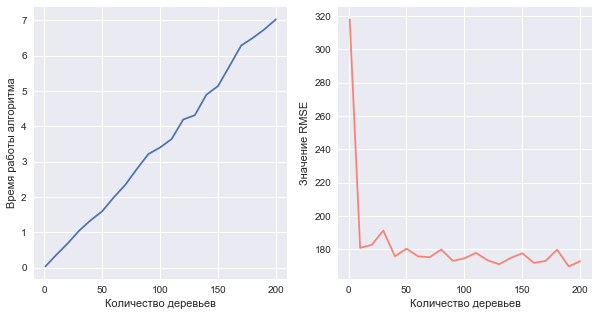

In [22]:
plt.style.use('seaborn')

f = plt.figure(figsize=(10, 5))
plt.title('Исследование влияния количества деревьев в алгоритме \'Случайный лес\'')
plt.subplot(121)
plt.plot(ns, ns_time)
#plt.yscale('log')
plt.ylabel('Время работы алгоритма')
plt.xlabel('Количество деревьев')

plt.subplot(122)
plt.plot(ns, ns_rmse, c='salmon')
#plt.yscale('log')
plt.ylabel('Значение RMSE')
plt.xlabel('Количество деревьев')
f.savefig("rf_n.pdf");

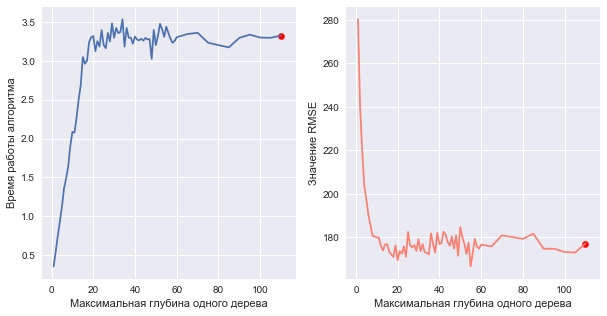

In [23]:
f = plt.figure(figsize=(10, 5))
plt.title('Исследование влияния глубины одного дерева в алгоритме \'Случайный лес\'')
plt.subplot(121)
d1 = depths.copy()
d1[-1] = 110
plt.plot(d1, depths_time)
plt.scatter(d1[-1], depths_time[-1], color='red', s=40, marker='o')
#plt.yscale('log')
plt.ylabel('Время работы алгоритма')
plt.xlabel('Максимальная глубина одного дерева')

plt.subplot(122)

plt.plot(d1, depths_rmse, c='salmon')
plt.scatter(d1[-1], depths_rmse[-1], color='red', s=40, marker='o')
#plt.yscale('log')
plt.ylabel('Значение RMSE')
plt.xlabel('Максимальная глубина одного дерева')
f.savefig("rf_depth.pdf")


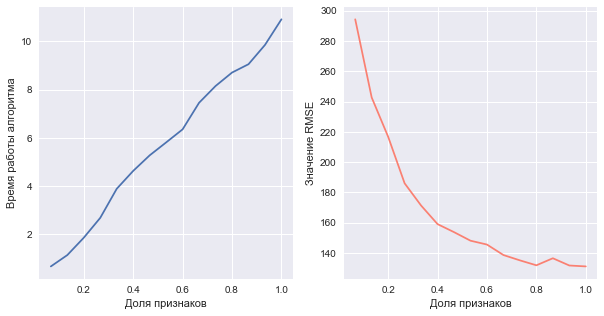

In [24]:
f = plt.figure(figsize=(10, 5))
plt.title('Исследование влияния доли признаков в алгоритме \'Случайный лес\'')
plt.subplot(121)
plt.plot(fs_sizes, fs_sizes_time)
#plt.yscale('log')
plt.ylabel('Время работы алгоритма')
plt.xlabel('Доля признаков')

plt.subplot(122)
plt.plot(fs_sizes, fs_sizes_rmse, c='salmon')
#plt.yscale('log')
plt.ylabel('Значение RMSE')
plt.xlabel('Доля признаков')
f.savefig("rf_feat.pdf")

In [25]:
ns = [1] + [i for i in range(10, 210, 10)]
ns_time = []
ns_rmse = []

for i in ns:
    rmse, sec = gb_research(n=i)
    ns_time.append(sec)
    ns_rmse.append(rmse)

In [26]:
depths = [i for i in range(1, 40)] + [40, None]
depths_time = []
depths_rmse = []

for i in depths:
    rmse, sec = gb_research(depth=i)
    depths_time.append(sec)
    depths_rmse.append(rmse)

In [27]:
fs_sizes = [x / 10 for x in range(1, 11)]
fs_sizes_time = []
fs_sizes_rmse = []

for i in fs_sizes:
    rmse, sec = gb_research(subsample_size=i)
    fs_sizes_time.append(sec)
    fs_sizes_rmse.append(rmse)

In [28]:
lrs = [i / 100 for i in range(1, 101)]
lrs_time = []
lrs_rmse = []

for i in lrs:
    rmse, sec = gb_research(lr=i)
    lrs_time.append(sec)
    lrs_rmse.append(rmse)

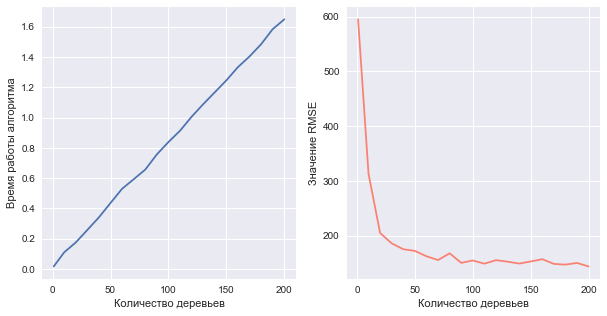

In [29]:

f = plt.figure(figsize=((10,5)))
plt.title('Исследование влияния количества деревьев в алгоритме \'Градиентный бустинг\'', size='large')
plt.subplot(121)
plt.plot(ns, ns_time)
#plt.yscale('log')
plt.ylabel('Время работы алгоритма')
plt.xlabel('Количество деревьев')

plt.subplot(122)
plt.plot(ns, ns_rmse, c='salmon')
#plt.yscale('log')
plt.ylabel('Значение RMSE')
plt.xlabel('Количество деревьев')
f.savefig("gb_n.pdf")

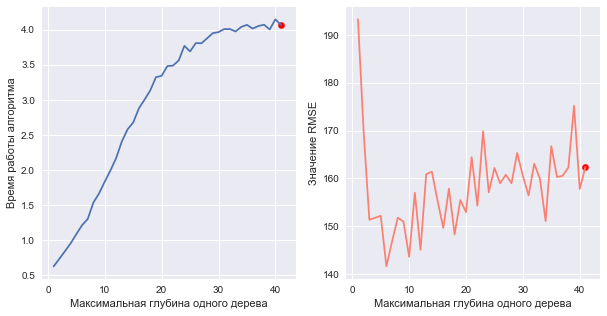

In [30]:
f = plt.figure(figsize=(10,5))
plt.title('Исследование влияния глубины одного дерева в алгоритме \'Градиентный бустинг\'')
plt.subplot(121)
d1 = depths.copy()
d1[-1] = 41
plt.plot(d1, depths_time)
plt.scatter(d1[-1], depths_time[-1], color='red', s=40, marker='o')
#plt.yscale('log')
plt.ylabel('Время работы алгоритма')
plt.xlabel('Максимальная глубина одного дерева')

plt.subplot(122)
plt.plot(d1, depths_rmse, c='salmon')
plt.scatter(d1[-1], depths_rmse[-1], color='red', s=40, marker='o')
#plt.yscale('log')
plt.ylabel('Значение RMSE')
plt.xlabel('Максимальная глубина одного дерева')
f.savefig("gb_depth.pdf")

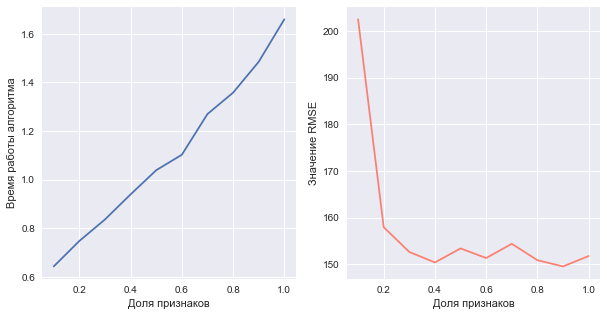

In [31]:
f = plt.figure(figsize=(10,5))
plt.title('Исследование влияния доли признаков в алгоритме \'Градиентный бустинг\'')
plt.subplot(121)
plt.plot(fs_sizes, fs_sizes_time)
#plt.yscale('log')
plt.ylabel('Время работы алгоритма')
plt.xlabel('Доля признаков')

plt.subplot(122)
plt.plot(fs_sizes, fs_sizes_rmse, c='salmon')
#plt.yscale('log')
plt.ylabel('Значение RMSE')
plt.xlabel('Доля признаков')
f.savefig("gb_feat.pdf")

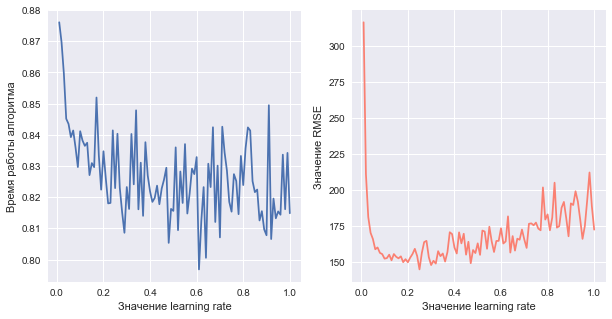

In [32]:
f = plt.figure(figsize=(10,5))
plt.title('Исследование влияния learning rate в алгоритме \'Градиентный бустинг\'')
plt.subplot(121)
plt.plot(lrs, lrs_time)
#plt.yscale('log')
plt.ylabel('Время работы алгоритма')
plt.xlabel('Значение learning rate')

plt.subplot(122)
plt.plot(lrs, lrs_rmse, c='salmon')
#plt.yscale('log')
plt.ylabel('Значение RMSE')
plt.xlabel('Значение learning rate')
f.savefig("gb_lr.pdf")

In [33]:
np.argmin(ns_rmse), ns[np.argmin(ns_rmse)], \
np.argmin(lrs_rmse), lrs[np.argmin(lrs_rmse)], \
np.argmin(depths_rmse), depths[np.argmin(depths_rmse)], \
np.argmin(fs_sizes_rmse), fs_sizes[np.argmin(fs_sizes_rmse)]

(20, 200, 24, 0.25, 5, 6, 8, 0.9)

In [36]:
rmse_gb, sec_gb = gb_research(n=200, lr=0.25, depth=6, subsample_size=0.9)
rmse_rf, sec_rf = rf_research(n=190, depth=55, subsample_size=1)

In [37]:
rmse_rf, rmse_gb, sec_rf, sec_gb

(131.48006233672635, 144.73919919846097, 20.85263729095459, 4.325243949890137)